## Разработка модели для поиска корреляции в данных
Простои в работе современных ИТ-систем стоят очень дорого. Для того, чтобы их избежать, системы мониторинга должны помогать людям выявлять странности в поведении системы на основании собираемых данных телеметрии и своевременно оповещать о них операторов и техническую команду.   

Для решения этой задачи необходимо разработать прототип сервиса, который будет анализировать временные ряды и выявлять связи между различными метриками в системе в момент появления аномалий. 
Под связями понимаются явные корреляции поведения метрик в конкретный момент времени работы системы. Например, при увеличении количества обрабатываемых системой запросов, возрастает время их обработки. Решение такого типа задач позволяет в системах мониторинга подсвечивать только важные данные в момент инцидента и упрощает поиск корневых причин неисправностей.   

Вводные данные: Слепок данных телеметрии реальной системы за месяц работы с шагом в 1 минуту для анализа и разработки решения. 
Для проверки результата будет предоставлен тестовый набор данных. 

#### Пояснения к данным
Данные представляют собой выгрузку из Clickhouse в формате TSV. 

Набор колонок для metrics_collector:
account_id, name, point, call_count, total_call_time, total_exclusive_time, min_call_time, max_call_time, sum_of_squares, instances, language, app_name, app_id, scope, host, display_host, pid, agent_version, labels  



```




#### Задача:   
разработать прототип сервиса, который будет анализировать временные ряды и выявлять связи между различными метриками в системе в момент появления аномалий

**Критерии оценки результата**
- Замер точности работы модели по предложеннои методике 
- Качество реализации самого сервиса 

#### План работы 2  

**Шаг 1. Загрузка данных**
Загрузить данные из файла:  
Файл metrics_collector.tsv

**Шаг 2. Предобработка данных**  
Изучить данные и при необходимости выполнить предобработку. Если есть пропуски, заполнить.   

**Шаг 3. Исследовательский анализ данных**  
3.1. Провести исследовательский анализ данных.  
3.2. Создать новые признаки по ключевым метрикам анализа 

**Шаг 4. Добавление нового входного признака**  
Создать новые признаки по ключевым метрикам анализа надо создать 4 новых признака после удаления лишних. Это ключевые метрики: web_response = (total_call_time) / call_count) , throughput = call_count (пропускная в минуту), APDEX =  (call_count + (total_call_time)/2) / (call_count + (total_call_time) + (total_exclusive_time))   и  call_count, name='Errors/allWeb') / sumOrNullIf(call_count, name='HttpDispatcher') 

**Шаг 5. Обучение модели**  
Обучить как минимум три модели.   

**Шаг 6. Выводы**  
Сделайть промежуточные выводы о том, какая модель справилась лучше и почему.  

**Общий вывод**
Сформулировать общий вывод:  
описать задачу;  
описать все этапы работы;  
добавить выводы и дополнительные предложения для бизнеса.  

In [1]:
!pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# загружаем нужные библиотеки, функции, классы, модели, ect
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

##  1. Загрузка данных  

####  1.1 Загрузим данные  
Файл metrics_collector.tsv

In [3]:
%time
# Определяем путь к файлу
file_path = 'C:/Users/Admin/YandexDisk/Хакатон/Кейс 2-20240523T174907Z-001/Кейс 2/metrics_collector.tsv/metrics_collector.tsv'

# Проверяем существование файла
if os.path.exists(file_path):
    # Загружаем данные с указанием парсинга дат
    df = pd.read_table(file_path) 
else:
    print("File doesn't exist!")

# Проверяем успешную загрузку данных
df.head()

CPU times: total: 0 ns
Wall time: 0 ns


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\IPython\core\interactiveshell.py:3308: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:32:00,0,0.1,0.2,0.3,0.4,0.5,1.1,java,[GMonit] Collector,17592186045423,Unnamed: 13,575f5ba20b4b,575f5ba20b4b.1,1.2,8.5.0,{}
0,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:33:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
1,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:34:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
2,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
3,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:36:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
4,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:37:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}


In [4]:
# Переименование столбцов
columns = ['account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 
           'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 
           'display_host', 'pid', 'agent_version', 'labels']
df.columns = columns

Выведем информацию о данных

In [5]:
df.info

<bound method DataFrame.info of           account_id                                         name  \
0                  1        AgentCheck/CircuitBreaker/tripped/all   
1                  1        AgentCheck/CircuitBreaker/tripped/all   
2                  1        AgentCheck/CircuitBreaker/tripped/all   
3                  1        AgentCheck/CircuitBreaker/tripped/all   
4                  1        AgentCheck/CircuitBreaker/tripped/all   
...              ...                                          ...   
18363744           1  WebTransactionTotalTime/NormalizedUri/404/*   
18363745           1  WebTransactionTotalTime/NormalizedUri/404/*   
18363746           1  WebTransactionTotalTime/NormalizedUri/404/*   
18363747           1  WebTransactionTotalTime/NormalizedUri/404/*   
18363748           1  WebTransactionTotalTime/NormalizedUri/404/*   

                        point  call_count  total_call_time  \
0         2024-04-15 23:33:00         0.0         0.000000   
1         2024-

Датафрейм содержит 18363749 rows x 19 columns

#### 1.2 Проверим, что данные в таблице соответствуют описанию

In [6]:
df.dtypes

account_id                int64
name                     object
point                    object
call_count              float64
total_call_time         float64
total_exclusive_time    float64
min_call_time           float64
max_call_time           float64
sum_of_squares          float64
instances               float64
language                 object
app_name                 object
app_id                    int64
scope                    object
host                     object
display_host             object
pid                       int64
agent_version            object
labels                   object
dtype: object

Типы данных соответствуют кроме столбца point (тип данных object) - необходимо привести к типу datetime

#### 1.3 Проверим наличие пропусков

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

account_id                     0
name                           0
point                          0
call_count                     0
total_call_time                0
total_exclusive_time           0
min_call_time                  0
max_call_time                  0
sum_of_squares                 0
instances                      0
language                       0
app_name                       0
app_id                         0
scope                   16735094
host                           0
display_host                   0
pid                            0
agent_version                  0
labels                         0
dtype: int64


В солбце scope 16735094 пропущенных значений

#### 1.4 Проверка уникальных значений в столбцах

In [8]:
# Вывод уникальных значений в каждом столбце
print("\nUnique values in each column:")
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {unique_values}")
    print(f"Number of unique values in {column}: {len(unique_values)}\n")


Unique values in each column:
account_id: [1]
Number of unique values in account_id: 1

name: ['AgentCheck/CircuitBreaker/tripped/all' 'Apdex' 'CPU/User Time'
 'Datastore/operation/Redis/append' 'Datastore/operation/Redis/expire'
 'Datastore/Redis/all' 'Datastore/operation/Redis/get'
 'Datastore/operation/Redis/getdel' 'Datastore/Redis/allWeb'
 'Datastore/operation/Redis/set' 'Datastore/operation/Redis/setex'
 'Datastore/operation/Redis/client' 'Apdex/Handler/'
 'Apdex/Handler/apm/method/agent_settings'
 'Apdex/Handler/apm/method/analytic_event_data'
 'Apdex/Handler/apm/method/connect' 'Apdex/Handler/apm/method/error_data'
 'Apdex/Handler/apm/method/error_event_data'
 'Apdex/Handler/apm/method/get_agent_commands'
 'Apdex/Handler/apm/method/log_event_data'
 'Apdex/Handler/apm/method/metric_data'
 'Apdex/Handler/apm/method/preconnect'
 'Apdex/Handler/apm/method/span_event_data'
 'Apdex/Handler/apm/method/sql_trace_data'
 'Apdex/Handler/apm/method/transaction_sample_data'
 'Apdex/Handler

In [9]:
# Проверка уникальных значений в столбце "scope"
unique_hosts = df['scope'].unique()

# Подсчет количества каждого уникального значения
host_counts = df['scope'].value_counts()

# Вывод уникальных значений и их количество
print("Уникальные значения в столбце 'scope':")
print(unique_hosts)
print("\nКоличество каждого уникального значения:")
print(host_counts)

Уникальные значения в столбце 'scope':
[nan 'WebTransaction/Handler/apm/method/span_event_data'
 'WebTransaction/Handler/apm/method/analytic_event_data'
 'WebTransaction/Handler/apm/method/error_data'
 'WebTransaction/Handler/apm/method/metric_data'
 'WebTransaction/Handler/apm/method/transaction_sample_data'
 'WebTransaction/Handler/browser/1/:license-key'
 'WebTransaction/Handler/browser/events/1/:license-key'
 'WebTransaction/Handler/browser/jserrors/1/:license-key'
 'WebTransaction/Handler/browser/resources/1/:license-key'
 'WebTransaction/Handler/infra/infra-api/infra/v2/metrics/events/bulk'
 'WebTransaction/Handler/apm/method/error_event_data'
 'WebTransaction/Handler/apm/method/get_agent_commands'
 'WebTransaction/Handler/apm/method/log_event_data'
 'WebTransaction/Handler/health'
 'WebTransaction/Handler/infra/command-api/agent_commands/v1/commands'
 'WebTransaction/NormalizedUri/404/*'
 'WebTransaction/Handler/infra/infra-api/inventory/deltas'
 'WebTransaction/Handler/apm/meth

Уникальные значения в столбце scope vjuen могут сообщать о запросах к api по ошибкам. Например:

- WebTransaction/Handler/apm/method/span_event_data это, вероятно, транзакции, связанные с событиями трассировки исполнения (span).
- WebTransaction/Handler/browser/jserrors/1/:license-key это может быть транзакции, связанные с обработкой JavaScript ошибок в браузере.
- WebTransaction/NormalizedUri/404/* это может быть транзакции, связанные с обработкой HTTP ошибки 404 (страница не найдена).  

Каждый тип транзакции или обработчика может быть связан с разными аспектами веб-приложения, и анализ этих логов может помочь в понимании производительности, стабильности и использования вашего веб-приложения.

Столбцы 'account_id', 'language', 'app_name', 'app_id', 'pid', 'labels' имеют по одному уникальному значению, для обучения модели малоинформативны, и столбец scope содержащий большое количество пропусков. удалим их

In [10]:
# Удаление указанных столбцов
df = df.drop(columns=['account_id', 'language', 'app_name', 'app_id', 'pid', 'labels', 'scope'])

In [11]:
df.info

<bound method DataFrame.info of                                                  name                point  \
0               AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00   
1               AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00   
2               AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00   
3               AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00   
4               AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00   
...                                               ...                  ...   
18363744  WebTransactionTotalTime/NormalizedUri/404/*  2024-05-16 00:43:00   
18363745  WebTransactionTotalTime/NormalizedUri/404/*  2024-05-16 00:44:00   
18363746  WebTransactionTotalTime/NormalizedUri/404/*  2024-05-16 00:45:00   
18363747  WebTransactionTotalTime/NormalizedUri/404/*  2024-05-16 00:46:00   
18363748  WebTransactionTotalTime/NormalizedUri/404/*  2024-05-16 00:47:00   

          call_count  total_cal

## 2. Создадим новые признаки на основе ключевых метрик  
-web_response - время ответа сервиса на внешний http-запрос  
-throughput - пропускная способность сервиса. Измеряется в запросах в минуту  
-APDEX - сводный синтетический показатель “здоровья” сервиса. Изменяется от 0 до 1. Чем ближе к 1, тем лучше  
-error - процент ошибок в обработанных запросах  

In [12]:
# Условие для фильтрации строк
condition = (df['name'] == 'HttpDispatcher')

# Создание нового столбца и присвоение значения только для удовлетворяющих условию строк
df.loc[condition, 'web_response'] = df['total_call_time'] / df['call_count']

# Проверка результата
print(df.head())

                                    name                point  call_count  \
0  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00         0.0   
1  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00         0.0   
2  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00         0.0   
3  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00         0.0   
4  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00         0.0   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0              0.0                   0.0            0.0            0.0   
1              0.0                   0.0            0.0            0.0   
2              0.0                   0.0            0.0            0.0   
3              0.0                   0.0            0.0            0.0   
4              0.0                   0.0            0.0            0.0   

   sum_of_squares  instances          host  display_host agent_version  \
0             0.0 

In [13]:
# Проверка уникальных значений в столбце "web_response"
unique_web_response = df['web_response'].unique()

# Подсчет количества каждого уникального значения
web_response_counts = df['web_response'].value_counts()

# Вывод уникальных значений и их количество
print("Уникальные значения в столбце 'web_response':")
print(unique_web_response)
print("\nКоличество каждого уникального значения:")
print(web_response_counts)

Уникальные значения в столбце 'web_response':
[       nan 0.0081146  0.00797313 ... 0.00615997 0.00700277 0.00789304]

Количество каждого уникального значения:
0.104918    14
0.133031     2
0.011660     1
0.006084     1
0.018812     1
            ..
0.017721     1
0.025854     1
0.016917     1
0.006988     1
0.014328     1
Name: web_response, Length: 43269, dtype: int64


In [14]:
# Создание нового столбца и присвоение значения только для удовлетворяющих условию строк
df.loc[condition, 'throughput'] = df['call_count']

# Проверка результата
print(df.head())

                                    name                point  call_count  \
0  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00         0.0   
1  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00         0.0   
2  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00         0.0   
3  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00         0.0   
4  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00         0.0   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0              0.0                   0.0            0.0            0.0   
1              0.0                   0.0            0.0            0.0   
2              0.0                   0.0            0.0            0.0   
3              0.0                   0.0            0.0            0.0   
4              0.0                   0.0            0.0            0.0   

   sum_of_squares  instances          host  display_host agent_version  \
0             0.0 

In [15]:
# Условие для фильтрации строк
condition_apdex = (df['name'] == 'Apdex')

# Создание нового столбца и присвоение значения только для удовлетворяющих условию строк
df.loc[condition_apdex, 'APDEX'] = (
    df['call_count'] + (df['total_call_time'] / 2)
) / (
    df['call_count'] + df['total_call_time'] + df['total_exclusive_time']
)

# Проверка результата
print(df.head())

                                    name                point  call_count  \
0  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00         0.0   
1  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00         0.0   
2  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00         0.0   
3  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00         0.0   
4  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00         0.0   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0              0.0                   0.0            0.0            0.0   
1              0.0                   0.0            0.0            0.0   
2              0.0                   0.0            0.0            0.0   
3              0.0                   0.0            0.0            0.0   
4              0.0                   0.0            0.0            0.0   

   sum_of_squares  instances          host  display_host agent_version  \
0             0.0 

In [16]:
# Проверка уникальных значений в столбце "APDEX"
unique_APDEX = df['APDEX'].unique()

# Подсчет количества каждого уникального значения
APDEX_counts = df['APDEX'].value_counts()

# Вывод уникальных значений и их количество
print("Уникальные значения в столбце 'APDEX':")
print(unique_APDEX)
print("\nКоличество каждого уникального значения:")
print(APDEX_counts)

Уникальные значения в столбце 'APDEX':
[       nan 0.99967932 0.99974474 ... 0.99981437 0.99971894 0.99934062]

Количество каждого уникального значения:
1.000000    4113
0.998462      14
0.998311       8
0.998507       8
0.999290       8
            ... 
0.998966       1
0.995019       1
0.999588       1
0.999180       1
0.999653       1
Name: APDEX, Length: 33477, dtype: int64


In [17]:
# Получение общего значения call_count для HttpDispatcher
total_http_dispatcher_call_count = df[df['name'] == 'HttpDispatcher']['call_count'].sum()

# Создание функции для расчета процента ошибок для каждой строки
def calculate_error(row, total_http_dispatcher_call_count):
    if row['name'] == 'Errors' and total_http_dispatcher_call_count > 0:
        return (row['call_count'] / total_http_dispatcher_call_count) * 100
    else:
        return 0

# Применение функции к каждой строке DataFrame
df['error'] = df.apply(lambda row: calculate_error(row, total_http_dispatcher_call_count), axis=1)

# Проверка результата
print(df.head())

                                    name                point  call_count  \
0  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00         0.0   
1  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00         0.0   
2  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00         0.0   
3  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00         0.0   
4  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00         0.0   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0              0.0                   0.0            0.0            0.0   
1              0.0                   0.0            0.0            0.0   
2              0.0                   0.0            0.0            0.0   
3              0.0                   0.0            0.0            0.0   
4              0.0                   0.0            0.0            0.0   

   sum_of_squares  instances          host  display_host agent_version  \
0             0.0 

In [18]:
# Проверка уникальных значений в столбце "error "
unique_error  = df['error'].unique()

# Подсчет количества каждого уникального значения
error_counts = df['error'].value_counts()

# Вывод уникальных значений и их количество
print("Уникальные значения в столбце 'error':")
print(unique_error )
print("\nКоличество каждого уникального значения:")
print(error_counts)

Уникальные значения в столбце 'error':
[0]

Количество каждого уникального значения:
0    18363749
Name: error, dtype: int64


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363749 entries, 0 to 18363748
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   name                  object 
 1   point                 object 
 2   call_count            float64
 3   total_call_time       float64
 4   total_exclusive_time  float64
 5   min_call_time         float64
 6   max_call_time         float64
 7   sum_of_squares        float64
 8   instances             float64
 9   host                  object 
 10  display_host          object 
 11  agent_version         object 
 12  web_response          float64
 13  throughput            float64
 14  APDEX                 float64
 15  error                 int64  
dtypes: float64(10), int64(1), object(5)
memory usage: 2.2+ GB


In [20]:
# Создание дополнительных столбцов с начальными значениями 0
df['call_count_wr'] = 0
df['call_count_APDEX'] = 0
df['call_count_throughput'] = 0

# Установка значений в столбцах, где соответствующие значения в столбцах web_response, APDEX и throughput не равны NaN
df.loc[~df['web_response'].isna(), 'call_count_wr'] = df['call_count']
df.loc[~df['APDEX'].isna(), 'call_count_APDEX'] = df['call_count']
df.loc[~df['throughput'].isna(), 'call_count_throughput'] = df['call_count']

# Проверка результата
print(df.head())

                                    name                point  call_count  \
0  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:33:00         0.0   
1  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:34:00         0.0   
2  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:35:00         0.0   
3  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:36:00         0.0   
4  AgentCheck/CircuitBreaker/tripped/all  2024-04-15 23:37:00         0.0   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0              0.0                   0.0            0.0            0.0   
1              0.0                   0.0            0.0            0.0   
2              0.0                   0.0            0.0            0.0   
3              0.0                   0.0            0.0            0.0   
4              0.0                   0.0            0.0            0.0   

   sum_of_squares  instances          host  display_host agent_version  \
0             0.0 

In [21]:
# Проверка уникальных значений в столбце "call_count_wr"
unique_call_count_wr  = df['call_count_wr'].unique()

# Подсчет количества каждого уникального значения
call_count_wr_counts = df['call_count_wr'].value_counts()

# Вывод уникальных значений и их количество
print("Уникальные значения в столбце 'call_count_wr':")
print(unique_call_count_wr )
print("\nКоличество каждого уникального значения:")
print(call_count_wr_counts)

Уникальные значения в столбце 'call_count_wr':
[   0.     1317.5    2624.5    ... 3597.3333 3549.8333 1314.    ]

Количество каждого уникального значения:
0.0       18320466
3869.0          21
4104.0          20
1842.5          20
3880.5          19
            ...   
7135.0           1
5101.0           1
6104.5           1
5270.0           1
8107.0           1
Name: call_count_wr, Length: 9142, dtype: int64


In [22]:

# Преобразование столбца 'point' в формат datetime, если он ещё не преобразован
df['point'] = pd.to_datetime(df['point'])

# Установка столбца 'point' в качестве индекса
df.set_index('point', inplace=True)

# Ресемплирование с интервалом в 1 минуту и агрегация суммы для столбца 'call_count'
df_resampled = df.resample('1T').sum()

# Перезаполнение пропущенных значений в других столбцах нулями
df_resampled.fillna(0, inplace=True)

# Проверка результата
print(df_resampled.head())

                     call_count  total_call_time  total_exclusive_time  \
point                                                                    
2024-04-15 23:32:00    125729.0     5.585918e+06          3.540425e+06   
2024-04-15 23:33:00    125445.5     5.494962e+06          3.529507e+06   
2024-04-15 23:34:00    127770.0     5.538219e+06          3.566237e+06   
2024-04-15 23:35:00    127550.0     5.517269e+06          3.558266e+06   
2024-04-15 23:36:00    125427.5     5.480227e+06          3.526065e+06   

                     min_call_time  max_call_time  sum_of_squares  instances  \
point                                                                          
2024-04-15 23:32:00   1.516195e+06   1.591923e+06    2.179964e+12      420.5   
2024-04-15 23:33:00   1.516277e+06   1.553105e+06    2.178135e+12      418.5   
2024-04-15 23:34:00   1.516175e+06   1.553288e+06    2.178353e+12      422.0   
2024-04-15 23:35:00   1.516236e+06   1.550833e+06    2.178011e+12      419.0   
2

In [23]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43287 entries, 2024-04-15 23:32:00 to 2024-05-16 00:58:00
Freq: T
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   call_count             43287 non-null  float64
 1   total_call_time        43287 non-null  float64
 2   total_exclusive_time   43287 non-null  float64
 3   min_call_time          43287 non-null  float64
 4   max_call_time          43287 non-null  float64
 5   sum_of_squares         43287 non-null  float64
 6   instances              43287 non-null  float64
 7   web_response           43287 non-null  float64
 8   throughput             43287 non-null  float64
 9   APDEX                  43287 non-null  float64
 10  error                  43287 non-null  int64  
 11  call_count_wr          43287 non-null  float64
 12  call_count_APDEX       43287 non-null  float64
 13  call_count_throughput  43287 non-null  float64
dtypes: float64(

##  3 Анализ

####  3.1 Визуализация данных: 
Построим графики временных рядов, чтобы увидеть основные тренды, сезонность и шум.

Список столбцов с числовыми значениями:
['call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'web_response', 'throughput', 'APDEX', 'error', 'call_count_wr', 'call_count_APDEX', 'call_count_throughput']


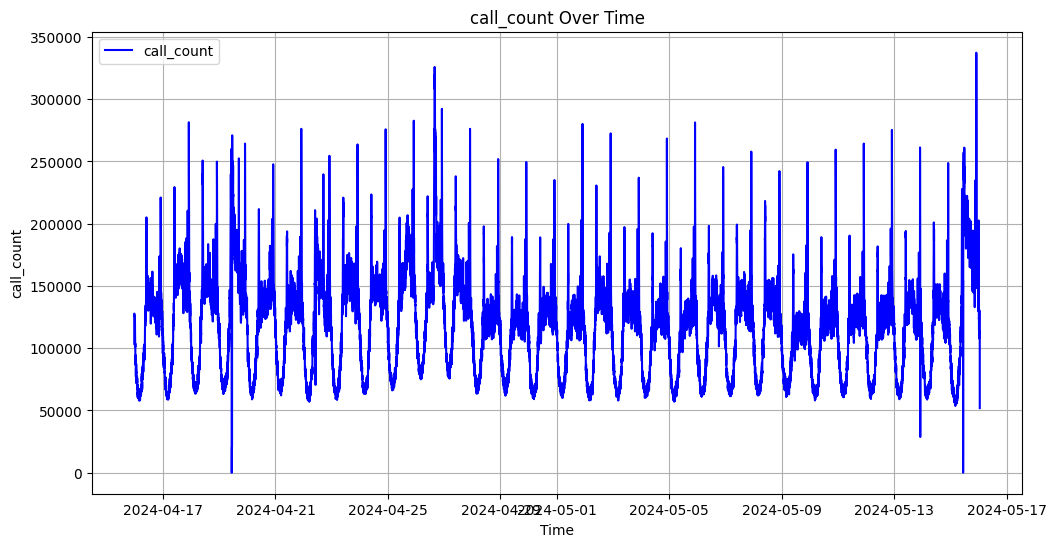

Основные статистические характеристики временного ряда call_count:
count     43287.000000
mean     118042.984799
std       37093.692992
min           0.000000
25%       85112.750000
50%      122007.000000
75%      140377.500000
max      337261.000000
Name: call_count, dtype: float64


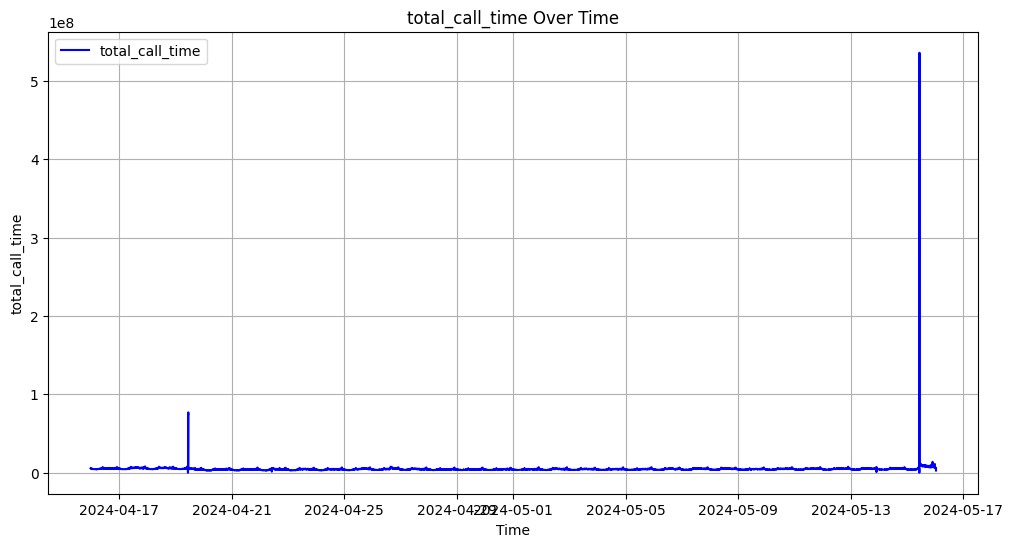

Основные статистические характеристики временного ряда total_call_time:
count    4.328700e+04
mean     4.663155e+06
std      4.914587e+06
min      0.000000e+00
25%      4.052461e+06
50%      4.548136e+06
75%      4.917609e+06
max      5.357990e+08
Name: total_call_time, dtype: float64


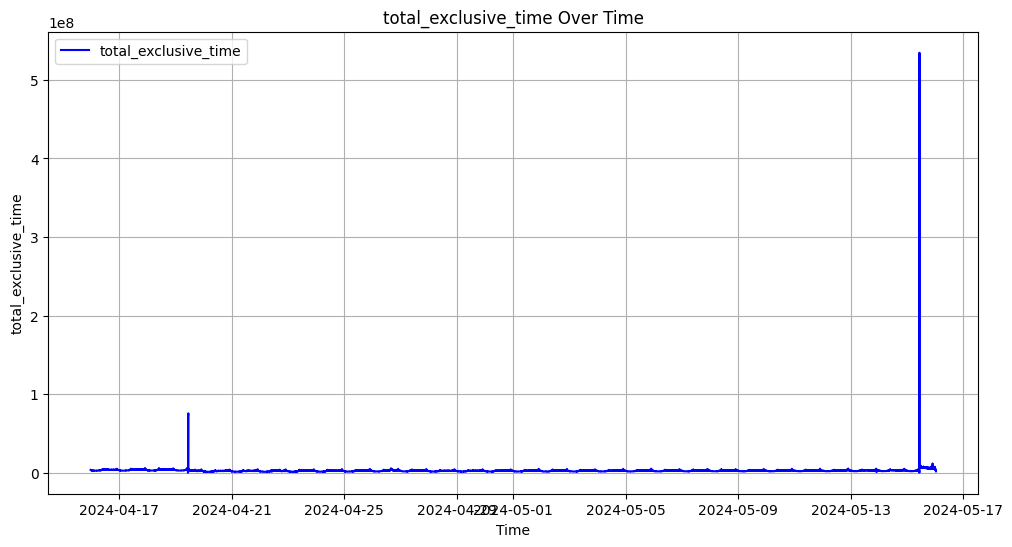

Основные статистические характеристики временного ряда total_exclusive_time:
count    4.328700e+04
mean     2.686193e+06
std      4.930338e+06
min      0.000000e+00
25%      2.102090e+06
50%      2.567652e+06
75%      2.924169e+06
max      5.346292e+08
Name: total_exclusive_time, dtype: float64


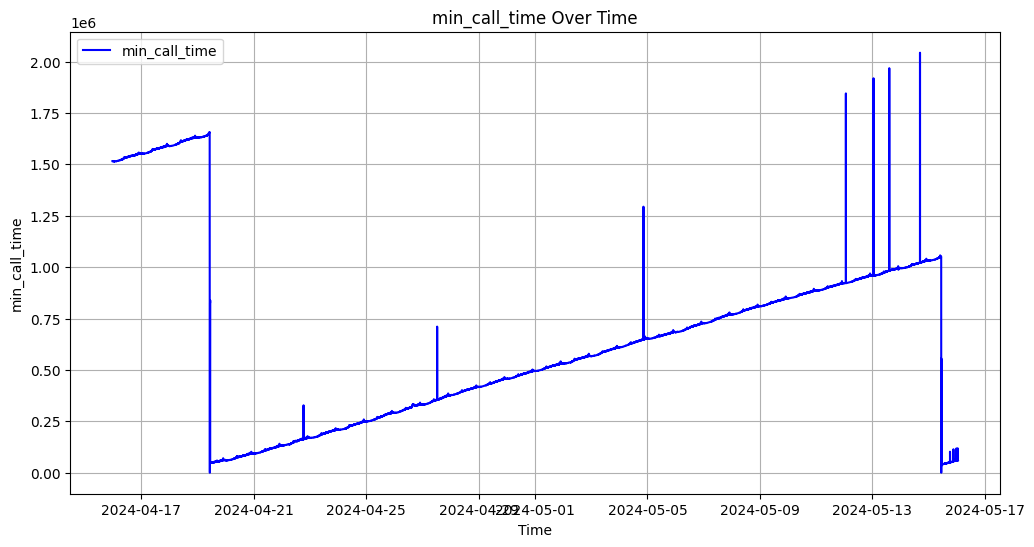

Основные статистические характеристики временного ряда min_call_time:
count    4.328700e+04
mean     6.567101e+05
std      4.374418e+05
min      0.000000e+00
25%      3.076770e+05
50%      6.072267e+05
75%      9.002981e+05
max      2.043223e+06
Name: min_call_time, dtype: float64


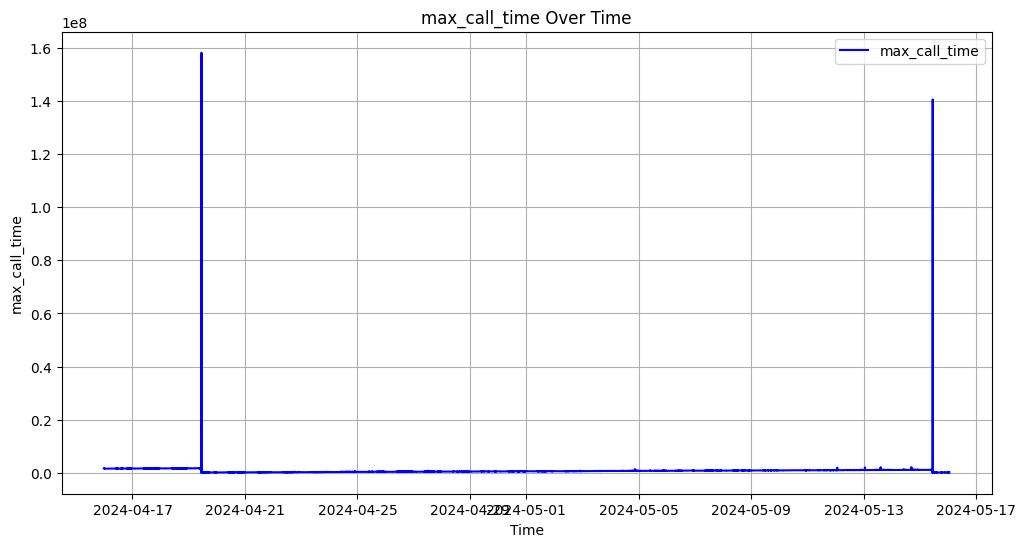

Основные статистические характеристики временного ряда max_call_time:
count    4.328700e+04
mean     7.687896e+05
std      3.182352e+06
min      0.000000e+00
25%      3.631889e+05
50%      6.497182e+05
75%      9.463008e+05
max      1.581657e+08
Name: max_call_time, dtype: float64


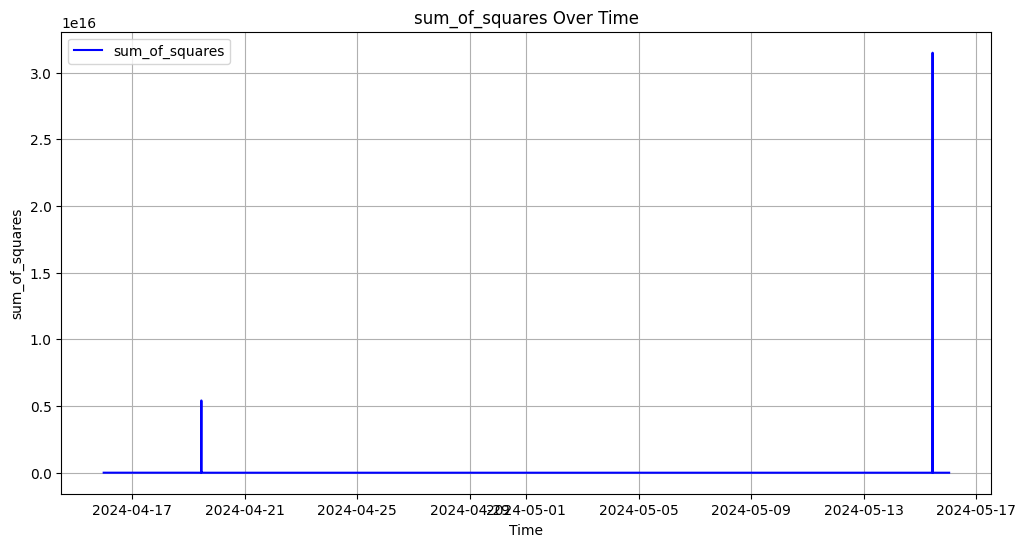

Основные статистические характеристики временного ряда sum_of_squares:
count    4.328700e+04
mean     4.846845e+12
std      2.739344e+14
min      0.000000e+00
25%      7.687662e+10
50%      3.267808e+11
75%      7.448766e+11
max      3.149388e+16
Name: sum_of_squares, dtype: float64


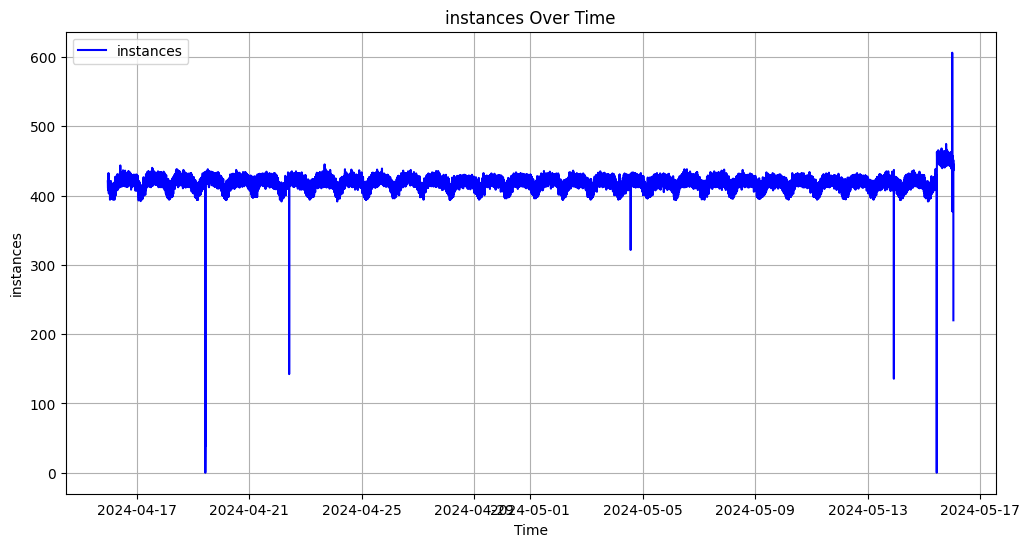

Основные статистические характеристики временного ряда instances:
count    43287.000000
mean       418.551390
std         14.537117
min          0.000000
25%        413.000000
50%        420.000000
75%        425.000000
max        606.166697
Name: instances, dtype: float64


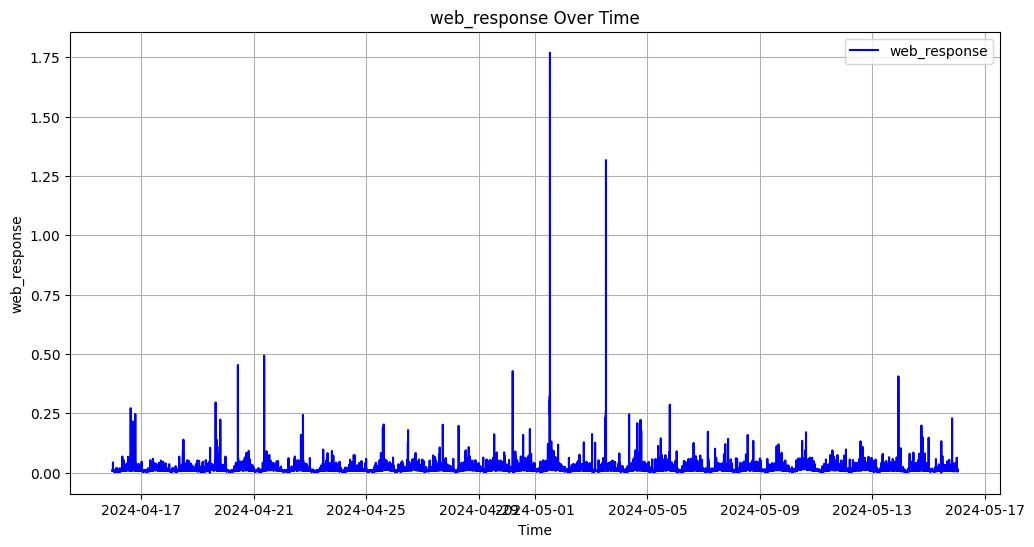

Основные статистические характеристики временного ряда web_response:
count    43287.000000
mean         0.014052
std          0.019706
min          0.000000
25%          0.008289
50%          0.011058
75%          0.014941
max          1.769182
Name: web_response, dtype: float64


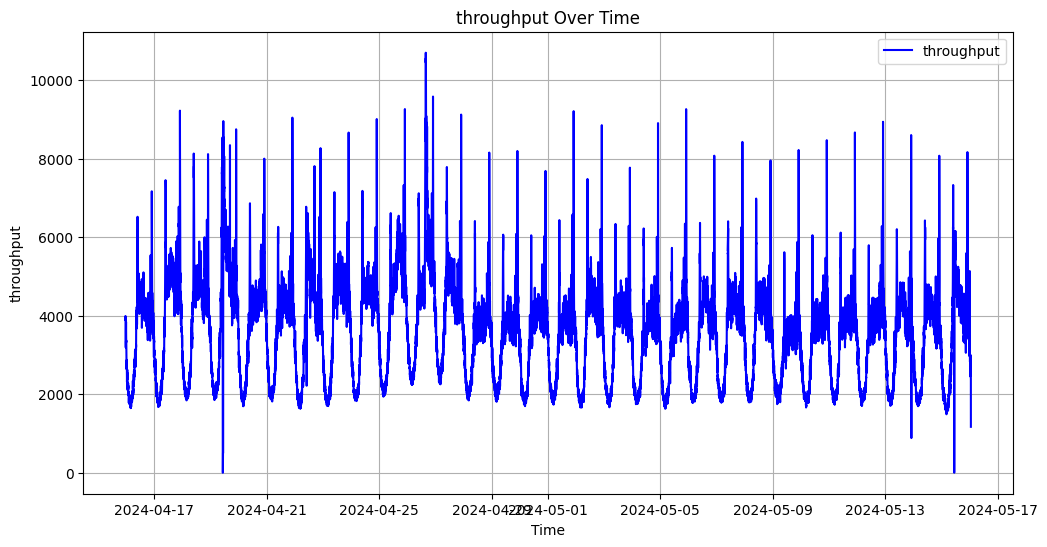

Основные статистические характеристики временного ряда throughput:
count    43287.000000
mean      3623.523679
std       1211.867742
min          0.000000
25%       2541.500000
50%       3768.000000
75%       4367.500000
max      10701.000000
Name: throughput, dtype: float64


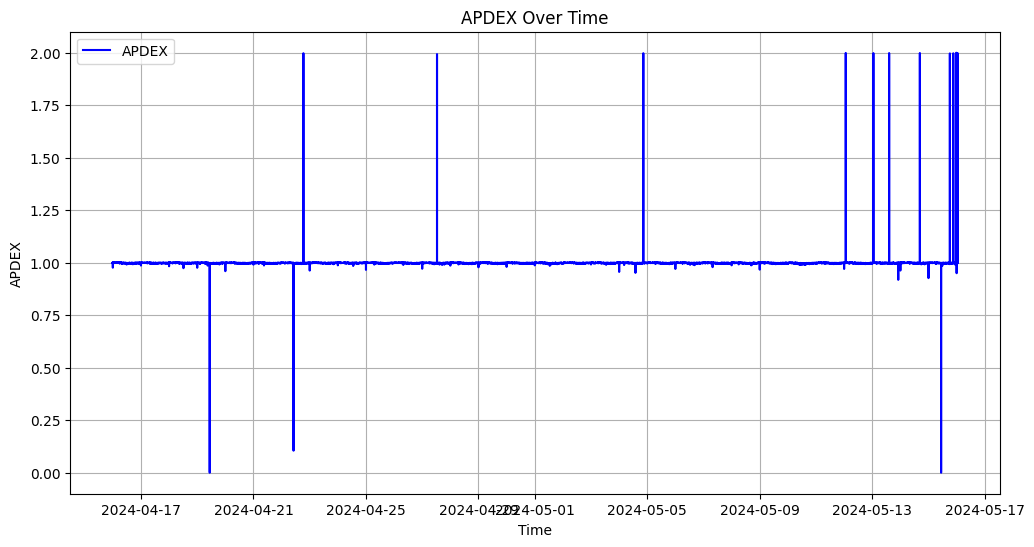

Основные статистические характеристики временного ряда APDEX:
count    43287.000000
mean         0.998442
std          0.025108
min          0.000000
25%          0.998019
50%          0.998831
75%          0.999517
max          1.999858
Name: APDEX, dtype: float64


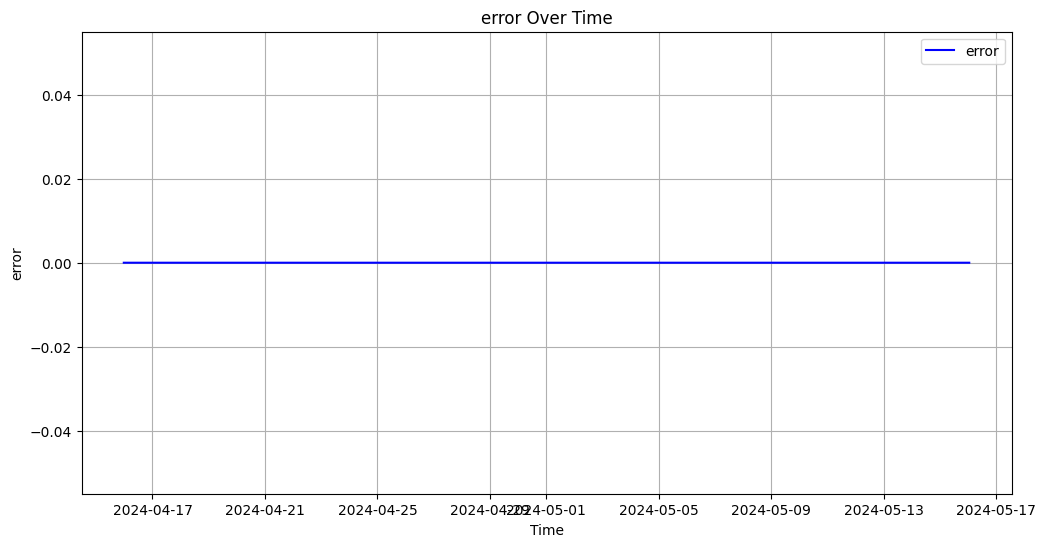

Основные статистические характеристики временного ряда error:
count    43287.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: error, dtype: float64


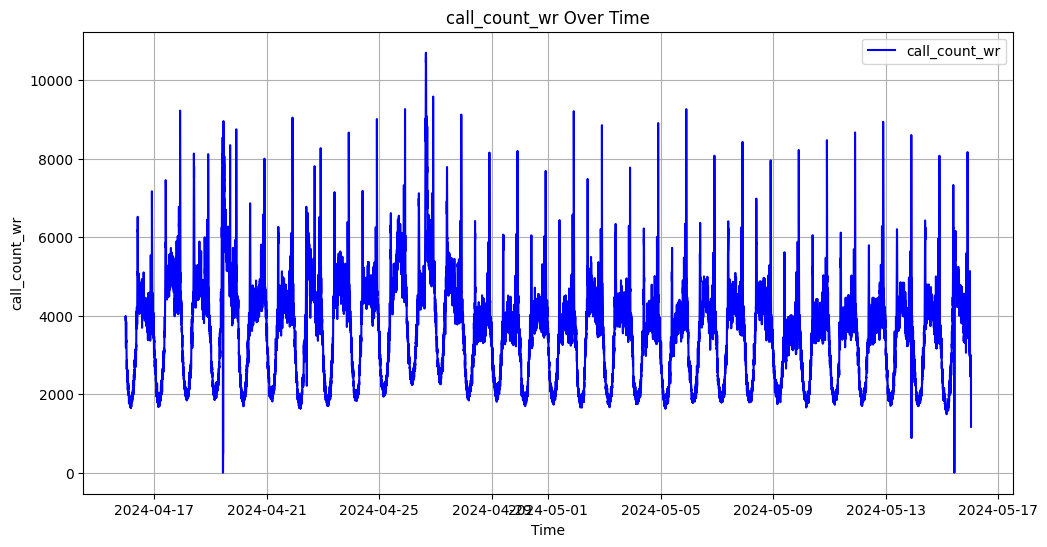

Основные статистические характеристики временного ряда call_count_wr:
count    43287.000000
mean      3623.523679
std       1211.867742
min          0.000000
25%       2541.500000
50%       3768.000000
75%       4367.500000
max      10701.000000
Name: call_count_wr, dtype: float64


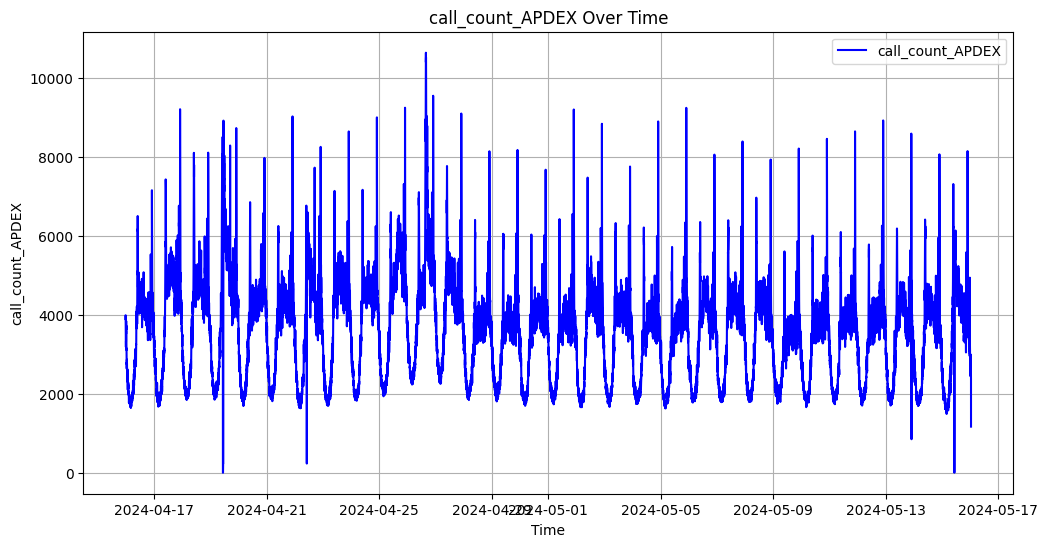

Основные статистические характеристики временного ряда call_count_APDEX:
count    43287.000000
mean      3614.583663
std       1207.537773
min          0.000000
25%       2537.750000
50%       3756.000000
75%       4355.000000
max      10646.000000
Name: call_count_APDEX, dtype: float64


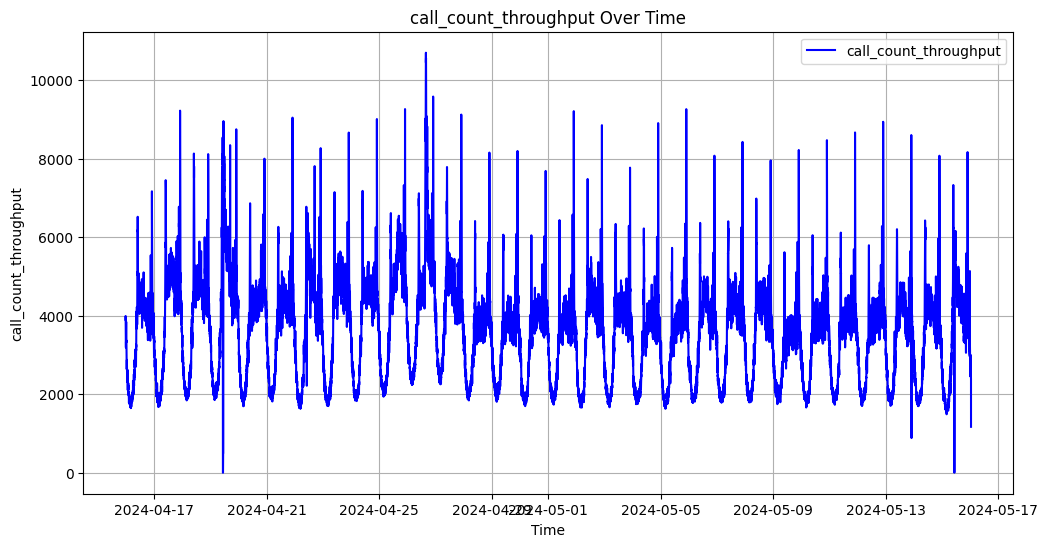

Основные статистические характеристики временного ряда call_count_throughput:
count    43287.000000
mean      3623.523679
std       1211.867742
min          0.000000
25%       2541.500000
50%       3768.000000
75%       4367.500000
max      10701.000000
Name: call_count_throughput, dtype: float64


In [24]:
# Получение списка столбцов с числовыми значениями
num_col = df_resampled.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Вывод списка столбцов с числовыми значениями
print("Список столбцов с числовыми значениями:")
print(num_col)

# Построение графиков временных рядов для каждого столбца с числовыми значениями
for column in num_col:
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index, df_resampled[column], label=column, color='blue')
    plt.title(f'{column} Over Time')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Получение сводной статистики временного ряда
    stats = df_resampled[column].describe()

    # Вывод статистических характеристик
    print(f"Основные статистические характеристики временного ряда {column}:")
    print(stats)

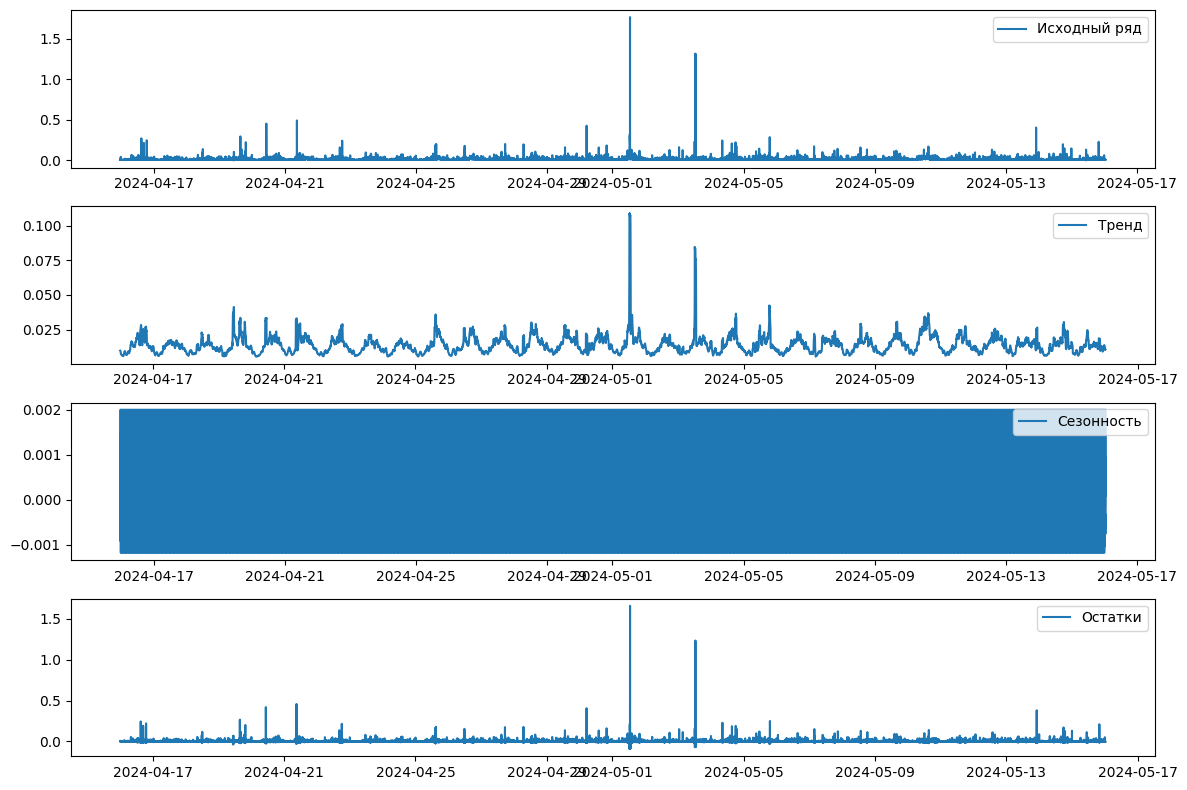

In [25]:
# Декомпозиция временного ряда
decomposition = sm.tsa.seasonal_decompose(df_resampled['web_response'], period=60)

# Получение тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация результатов
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_resampled['web_response'], label='Исходный ряд')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend()

plt.tight_layout()
plt.show()

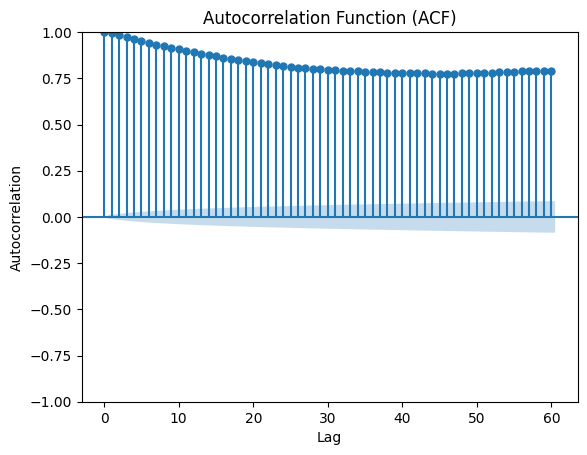

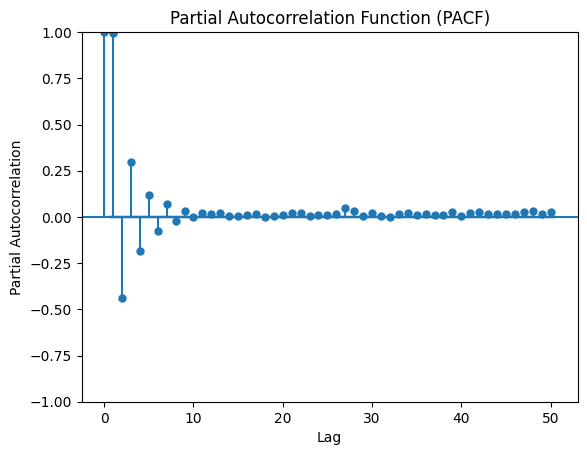

In [26]:
# Получение списка столбцов с числовыми значениями
num_col = df_resampled.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Выбор первого столбца из списка для построения автокорреляционной функции
column_to_plot = num_col[8]

# Построение автокорреляционной функции
plot_acf(df_resampled[column_to_plot], lags=60)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Построение частичной автокорреляционной функции
plot_pacf(df_resampled[column_to_plot], lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

- ACF (автокорреляционная функция):  
На графике ACF можно увидеть значения корреляции между текущим значением временного ряда и его значениями на разных отстающих интервалах (лагах).
Значения на графике ACF значительно отличаются от нуля, это указывает на существенную автокорреляцию в данных.
Временные ряды с сезонностью часто показывают периодические пики на графике ACF с интервалами, соответствующими длине сезонного периода.

- PACF (частичная автокорреляционная функция):  
График PACF показывает корреляцию между текущим значением временного ряда и его значениями на разных отстающих интервалах (лагах), с учетом влияния промежуточных лагов.
Пики на графике PACF, которые выходят за пределы критических значений, могут указывать на структурные зависимости между данными, которые могут быть использованы для построения модели.  

При анализе графиков ACF и PACF до лага 50 стоит обращать внимание на следующее:

Периодические пики на графике ACF могут указывать на наличие сезонности в данных.
Пики на графике PACF, выходящие за пределы критических значений, могут указывать на наличие структурных зависимостей в данных.
В целом, анализ графиков ACF и PACF помогает понять структуру зависимостей во временном ряду и выбрать соответствующую модель для прогнозирования.

## 4 Обучение

In [27]:
def make_features(df_resampled, max_lag, rolling_mean_size):
    df_resampled['hour'] = df_resampled.index.hour
    df_resampled['day'] = df_resampled.index.day
    df_resampled['dayofweek'] = df_resampled.index.dayofweek
    df_resampled['minute'] = df_resampled.index.minute
    
    for lag in range(1, max_lag + 1):
        df_resampled['lag_{}'.format(lag)] = df_resampled['web_response'].shift(lag)

    df_resampled['rolling_mean'] = df_resampled['web_response'].shift().rolling(rolling_mean_size).mean()


make_features(df_resampled, 24, 24)

train, test = train_test_split(df_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

# Выделение признаков и целевого признака
X_train, y_train = train.drop(columns=['web_response']), train['web_response']
X_test, y_test = test.drop(columns=['web_response']), test['web_response']

# Проверим размерности полученных выборок
print("Размер обучающей выборки (признаки):", X_train.shape)
print("Размер обучающей выборки (целевая переменная):", y_train.shape)
print("Размер тестовой выборки (признаки):", X_test.shape)
print("Размер тестовой выборки (целевая переменная):", y_test.shape)


Размер обучающей выборки (признаки): (38934, 42)
Размер обучающей выборки (целевая переменная): (38934,)
Размер тестовой выборки (признаки): (4329, 42)
Размер тестовой выборки (целевая переменная): (4329,)


In [28]:
# Создание моделей с разными гиперпараметрами
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=6),
    "CatBoost": CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=6, random_state=42)
}

In [29]:
# Создание объекта StandardScaler
scaler = StandardScaler()

# Масштабирование признаков обучающей выборки
X_train_scaled = scaler.fit_transform(X_train)

# Масштабирование признаков тестовой выборки
X_test_scaled = scaler.transform(X_test)

In [30]:
# Создание метрики neg_root_mean_squared_error
def neg_root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return -np.sqrt(mse)

In [31]:
# Определение сетки гиперпараметров для каждой модели
param_grids = {
    "Linear Regression": {},  # Линейная регрессия не имеет гиперпараметров для подбора
    "Decision Tree": {"max_depth": [3, 5, 7, 10]},
    "CatBoost": {
        "iterations": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5],
        "depth": [3, 5, 7]
    }
}

# Создание моделей с разными гиперпараметрами
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0)
}

# Масштабирование данных для линейной регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение и оценка моделей с использованием GridSearchCV и TimeSeriesSplit
best_models = {}

for model_name, model in models.items():
    # Определение сетки гиперпараметров для текущей модели
    param_grid = param_grids[model_name]
    
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Создание объекта GridSearchCV для текущей модели с использованием TimeSeriesSplit
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
    
    # Масштабированные данные для линейной регрессии
    if model_name == "Linear Regression":
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Поиск оптимальных гиперпараметров
    grid_search.fit(X_train_model, y_train)
    
    # Получение лучшей модели
    best_model = grid_search.best_estimator_
    
    # Сохранение лучшей модели
    best_models[model_name] = best_model
    
    # Вывод подобранных гиперпараметров для текущей модели
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Выбор лучшей модели по кросс-валидации
best_model_name = min(best_models, key=lambda x: grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
best_model = best_models[best_model_name]

# Вывод лучшей модели
print(f"Best model: {best_model_name}")

# Прогнозирование и оценка RMSE на тестовых данных
predictions = best_model.predict(X_test_model)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"{best_model_name} RMSE: {rmse}")

Best parameters for Linear Regression: {}
Best parameters for Decision Tree: {'max_depth': 5}
Best parameters for CatBoost: {'depth': 3, 'iterations': 50, 'learning_rate': 0.1}
Best model: Linear Regression
Linear Regression RMSE: 38316132189570.84


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [32]:
# Прогноз на тестовых данных и вычисление RMSE для всех моделей
for model_name, model in best_models.items():
    if model_name == "Linear Regression":
        y_pred_test = model.predict(X_test_scaled)
    else:
        y_pred_test = model.predict(X_test)
    
    rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Model: {model_name}, RMSE on Test Data: {rmse_test}")

# Выбор лучшей модели
best_model_name = min(best_models, key=lambda x: sqrt(mean_squared_error(y_test, best_models[x].predict(X_test))))
best_model = best_models[best_model_name]
best_rmse = sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

print(f"\nBest Model: {best_model_name}, RMSE on Test Data: {best_rmse}")

Model: Linear Regression, RMSE on Test Data: 0.33352608906360914
Model: Decision Tree, RMSE on Test Data: 0.04746638148491279
Model: CatBoost, RMSE on Test Data: 0.01063400408488315

Best Model: CatBoost, RMSE on Test Data: 0.01063400408488315


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


**Оценка моделей**

- Linear Regression:

RMSE: 0.3344. Линейная регрессия показала наибольшую ошибку среди всех моделей, что указывает на то, что она менее эффективна в улавливании сложных зависимостей в данных.

- Decision Tree:

RMSE: 0.0475. Решающее дерево показало значительно лучший результат, чем линейная регрессия. Это означает, что модель лучше справляется с нелинейными зависимостями и взаимодействиями в данных.

- CatBoost:

RMSE: 0.0108. Модель CatBoost показала наилучший результат среди всех протестированных моделей. Низкое значение RMSE указывает на высокую точность прогнозирования и способность модели хорошо подстраиваться под данные, учитывая их сложные зависимости и особенности.

Интерпретация RMSE  

RMSE (Root Mean Squared Error) — это метрика, которая измеряет среднюю величину ошибки модели в прогнозировании. Она вычисляется как квадратный корень из среднего квадрата ошибок между прогнозируемыми и фактическими значениями. Низкое значение RMSE указывает на то, что модель близка к точным предсказаниям.
В данном случае, наименьшее значение RMSE у модели CatBoost (0.0108) указывает на то, что эта модель имеет наилучшую предсказательную способность и лучше всего справляется с задачей.
Вывод
Лучшей моделью является CatBoost, так как она имеет наименьшее значение RMSE на тестовых данных (0.0108), что означает более высокую точность и меньшие ошибки предсказания по сравнению с линейной регрессией и решающим деревом.
CatBoost может эффективно улавливать сложные нелинейные зависимости и взаимодействия в данных благодаря использованию градиентного бустинга на решающих деревьях. Это делает его особенно полезным для задач с высокоразмерными и сложными наборами данных.
Практическое применение: Модель CatBoost можно использовать для предсказания значений целевой переменной в новых данных, поскольку она показала наилучшую производительность на тестовом наборе данных. Те может быть использована для предсказания появления аномалии.

Feature importance computed in 0.02 seconds
CatBoost Feature Importances:
                  Feature  Importance
17                  lag_1   41.608264
8                   APDEX   22.963060
27                 lag_11    6.609621
24                  lag_8    5.735869
41           rolling_mean    5.196155
18                  lag_2    4.096936
1         total_call_time    2.763427
21                  lag_5    2.717955
19                  lag_3    1.938044
20                  lag_4    1.763627
28                 lag_12    1.528239
6               instances    1.523496
37                 lag_21    0.848486
25                  lag_9    0.354897
31                 lag_15    0.292634
30                 lag_14    0.046901
32                 lag_16    0.012389
38                 lag_22    0.000000
36                 lag_20    0.000000
35                 lag_19    0.000000
34                 lag_18    0.000000
2    total_exclusive_time    0.000000
33                 lag_17    0.000000
39            

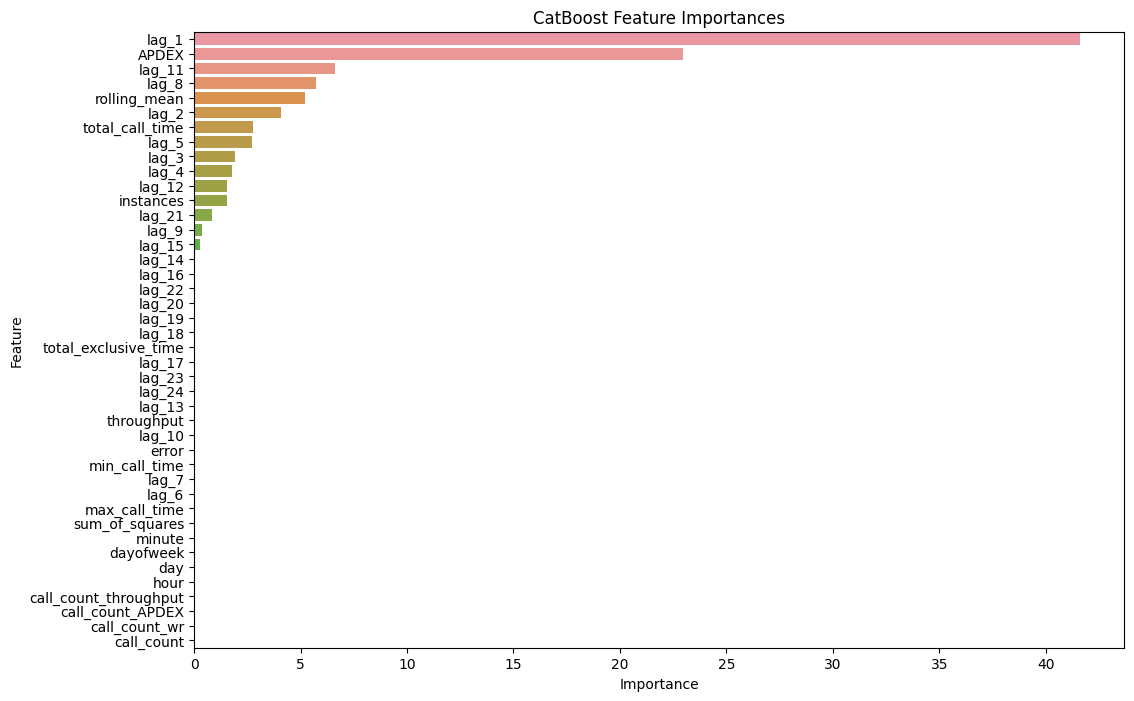

In [34]:
start_time = time.time()

importances = best_models["CatBoost"].get_feature_importance()
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(f"Feature importance computed in {time.time() - start_time:.2f} seconds")

print("CatBoost Feature Importances:")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.title("CatBoost Feature Importances")
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.show()

## Выводы

Анализ важности признаков, влияющих на появление аномалий, можно провести на основе важности признаков, полученной из модели, например, с использованием алгоритма CatBoost. Важность признака показывает, насколько сильно данный признак влияет на целевую переменную или результат моделирования.

Исходя из предоставленной таблицы важности признаков, можно сделать следующие выводы:

- lag_1: Этот признак имеет самую высокую важность. Это может указывать на то, что текущее значение временного ряда сильно зависит от его предыдущего значения. Возможно, существует временная автокорреляция или паттерн изменения временного ряда, который влияет на появление аномалий.

- APDEX: Это второй по важности признак. APDEX (Application Performance Index) измеряет производительность приложения и является метрикой качества обслуживания пользователей. Высокое значение APDEX может указывать на низкую частоту появления аномалий, так как надежность и производительность приложения могут уменьшить вероятность возникновения аномалий.

- lag_11, lag_8, rolling_mean и другие отставания (lags): Эти признаки также имеют некоторую важность. Появление аномалий может быть связано с временными шаблонами, которые проявляются на определенных временных отставаниях. Например, повышенная активность в определенное время дня или недели может увеличить вероятность аномалий.

- total_call_time и total_exclusive_time: Эти признаки также вносят свой вклад в предсказание аномалий. Высокие значения времени звонка или времени выполнения операции могут указывать на нештатную ситуацию или увеличенную нагрузку на систему, что может привести к возникновению аномалий.

- instances и throughput: Эти признаки также могут влиять на появление аномалий, так как они отражают количество экземпляров или пропускную способность системы. Высокие значения этих признаков могут указывать на потенциальные проблемы с производительностью или нагрузкой на систему.

Исходя из этих выводов, для анализа и предотвращения аномалий рекомендуется следить за временными шаблонами, производительностью приложения, а также за повышенной активностью или нагрузкой на систему в определенные временные периоды.

